## Simulated Data

In [1]:
import pandas as pd
import numpy as np

np.random.seed(42)

n_units = 10           # 10 units
n_periods = 20        # 20 times
treated_ids = [6, 7, 8, 9, 10]
post_start_time = 15   # treated starting from time 15

unit_effects = {i: np.random.uniform(5, 15) for i in range(1, n_units + 1)}
time_trends = {t: np.sin(t / 2) + (t * 0.1) for t in range(1, n_periods + 1)}

beta_1, beta_2 = 1.5, -0.8

rows = []
for unit in range(1, n_units + 1):
    for time in range(1, n_periods + 1):

        is_treated_unit = unit in treated_ids
        is_post_period = time >= post_start_time
        treated = 1 if (is_treated_unit and is_post_period) else 0
        
        cov_1 = np.random.normal(loc=unit*0.1, scale=1) 
        cov_2 = np.random.uniform(0, 5)               
        
        # constructing outcome: Y = FE_unit + FE_time + X*Beta + ATT*D + Noise)
        # assume that ATT = 5
        att = 5 if treated == 1 else 0
        noise = np.random.normal(0, 0.5)
        
        outcome = (unit_effects[unit] + 
                   time_trends[time] + 
                   cov_1 * beta_1 + 
                   cov_2 * beta_2 + 
                   att + 
                   noise)
        
        rows.append([unit, time, treated, outcome, cov_1, cov_2])

data = pd.DataFrame(rows, columns=["unit", "time", "treated", "outcome", "x1", "x2"])

print(f"shape: {data.shape}")
print(f"treated units: {treated_ids}")
print(f"post treatment terms: {list(range(post_start_time, n_periods + 1))}")
print(data.head())

shape: (200, 6)
treated units: [6, 7, 8, 9, 10]
post treatment terms: [15, 16, 17, 18, 19, 20]
   unit  time  treated    outcome        x1        x2
0     1     1        0   8.314595 -0.369474  0.909125
1     1     2        0   6.518735 -0.471380  2.623782
2     1     3        0   4.876964 -1.624918  3.059264
3     1     4        0   7.725979 -0.328046  1.831809
4     1     5        0  11.280763  1.565649  0.998369


In [2]:
from sdid import SyntheticDID

# sdid with covariates
model0 = SyntheticDID(omega_type="parallel")
model0.fit(data, 'outcome', 'unit', 'time', 'treated', covariate_cols=["x1", "x2"])

# sdid without covariates
model1 = SyntheticDID(omega_type="parallel")
model1.fit(data, 'outcome', 'unit', 'time', 'treated')

# sc with covariates
model2 = SyntheticDID(omega_type="match")
model2.fit(data, 'outcome', 'unit', 'time', 'treated', covariate_cols=["x1", "x2"])

# did with covariates
model3 = SyntheticDID(zeta_omega="inf", zeta_lambda="inf")
model3.fit(data, 'outcome', 'unit', 'time', 'treated', covariate_cols=["x1", "x2"])

check data and transform ...
optimizing ...
estimating ...
Done!
check data and transform ...
optimizing ...
estimating ...
Done!
check data and transform ...
optimizing ...
estimating ...
Done!
check data and transform ...
optimizing ...
estimating ...
Done!


estimated ATT = 4.796178076010272


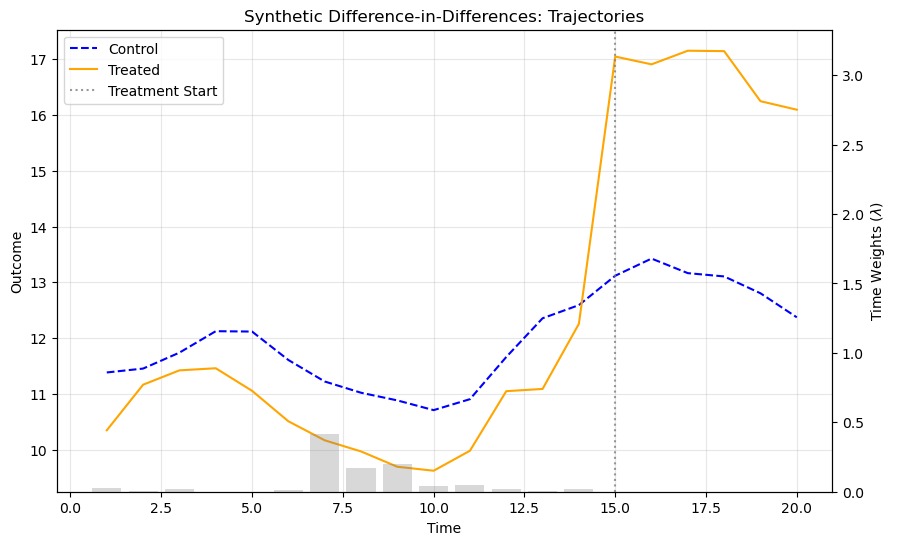

<Axes: title={'center': 'Synthetic Difference-in-Differences: Trajectories'}, xlabel='Time', ylabel='Outcome'>

In [3]:
print(f"estimated ATT = {model0.ATT_diff}")
model0.plot_trajectories()

estimated ATT = 5.427050560234464


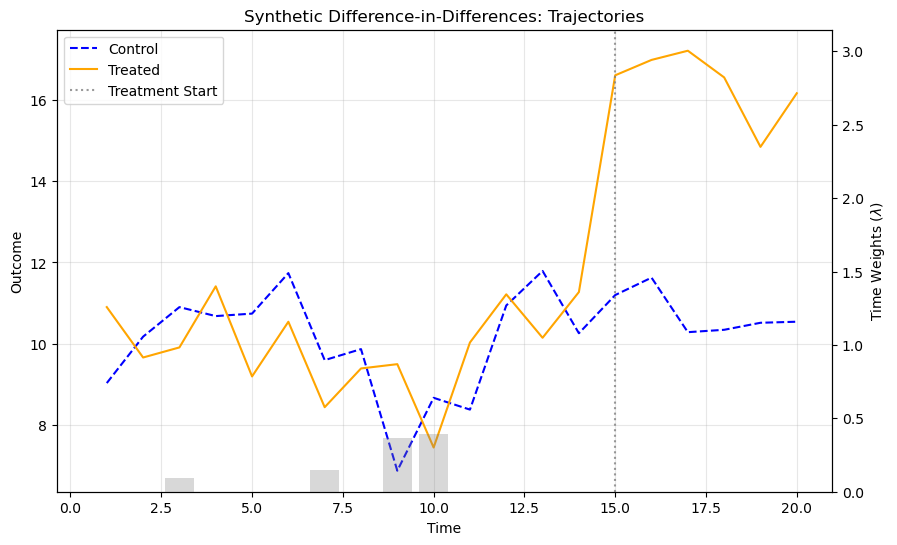

<Axes: title={'center': 'Synthetic Difference-in-Differences: Trajectories'}, xlabel='Time', ylabel='Outcome'>

In [4]:
print(f"estimated ATT = {model1.ATT_diff}")
model1.plot_trajectories()

estimated ATT = 4.796167288254978


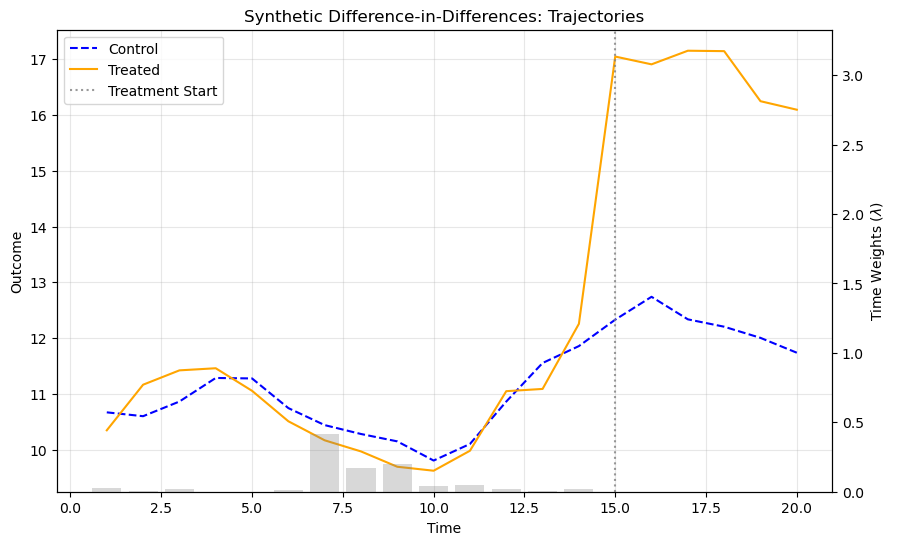

<Axes: title={'center': 'Synthetic Difference-in-Differences: Trajectories'}, xlabel='Time', ylabel='Outcome'>

In [5]:
print(f"estimated ATT = {model2.ATT_diff}")
model2.plot_trajectories()

estimated ATT = 4.614953625764918


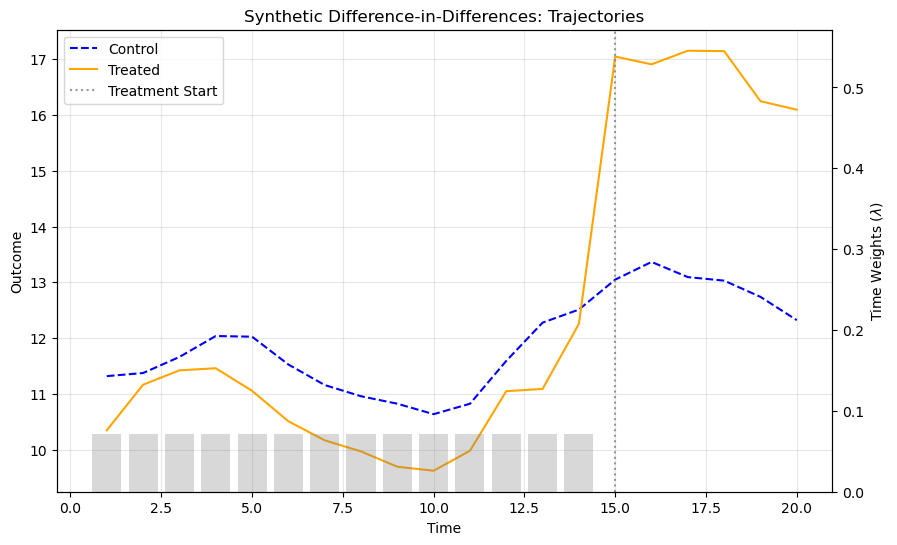

<Axes: title={'center': 'Synthetic Difference-in-Differences: Trajectories'}, xlabel='Time', ylabel='Outcome'>

In [6]:
print(f"estimated ATT = {model3.ATT_diff}")
model3.plot_trajectories()

## Real Data

In [1]:
import pandas as pd

dt = pd.read_csv("https://github.com/d2cml-ai/Synthdid.jl/raw/stag_treat/data/california_prop99.csv", sep=";")

dt.head()

,State,Year,PacksPerCapita,treated
0,Alabama,1970,89.800003,0
1,Arkansas,1970,100.300003,0
2,Colorado,1970,124.800003,0
3,Connecticut,1970,120.000000,0
4,Delaware,1970,155.000000,0


In [2]:
from sdid import SyntheticDID

# sdid
model1 = SyntheticDID()
model1.fit(dt, 'PacksPerCapita', 'State', 'Year', 'treated')

# sc
model2 = SyntheticDID(omega_type="match")
model2.fit(dt, 'PacksPerCapita', 'State', 'Year', 'treated')

# sc with negative weights
model3 = SyntheticDID(omega_type="match", negative_omega=True)
model3.fit(dt, 'PacksPerCapita', 'State', 'Year', 'treated')

# sdid with sparse estimation for omegas
model4 = SyntheticDID(sparse_threshold=0.1, zeta_omega=0)
model4.fit(dt, 'PacksPerCapita', 'State', 'Year', 'treated')

check data and transform ...
optimizing ...
estimating ...
Done!
check data and transform ...
optimizing ...
estimating ...
Done!
check data and transform ...
optimizing ...
estimating ...
Done!
check data and transform ...
optimizing ...
estimating ...
Done!


-12.593275741919133
-15.60377621195305


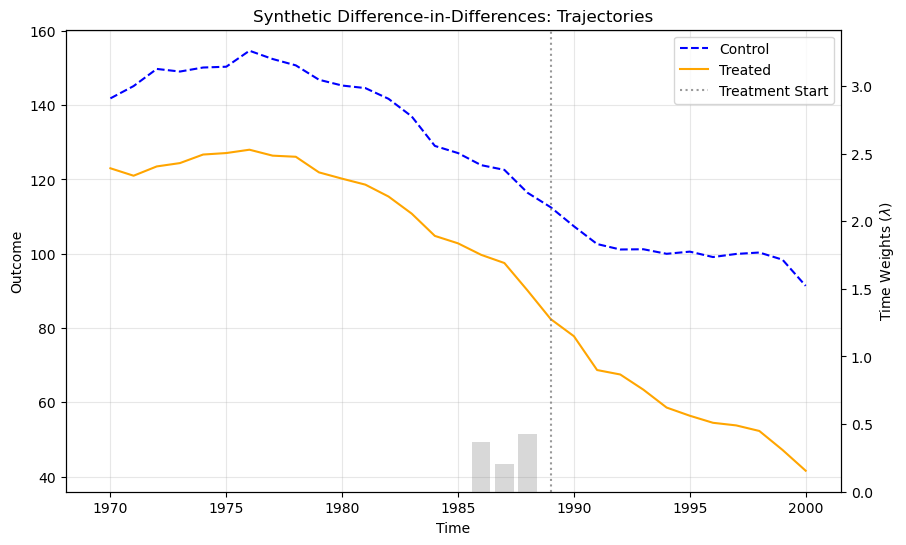

In [5]:
print(model1.ATT)
print(model1.ATT_diff)
model1.plot_trajectories()

-16.615587858754047
-19.771750575121345


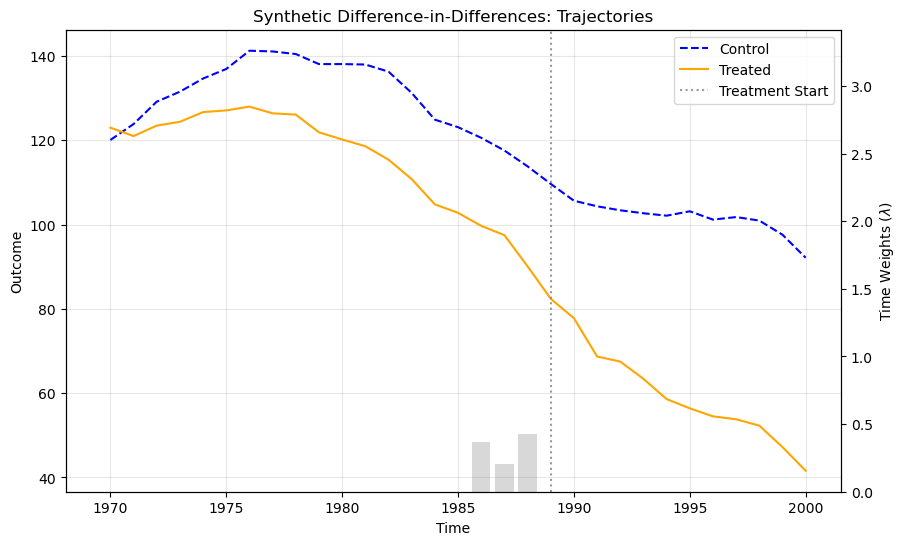

<Axes: title={'center': 'Synthetic Difference-in-Differences: Trajectories'}, xlabel='Time', ylabel='Outcome'>

In [10]:
print(model2.ATT)
print(model2.ATT_diff)
model2.plot_trajectories()

-15.627405751562558
-17.626377204871755


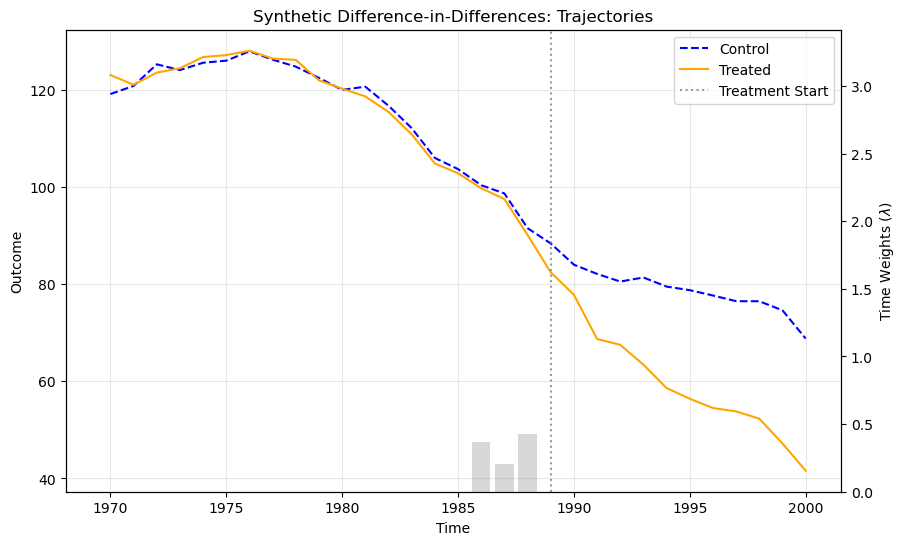

<Axes: title={'center': 'Synthetic Difference-in-Differences: Trajectories'}, xlabel='Time', ylabel='Outcome'>

In [11]:
print(model3.ATT)
print(model3.ATT_diff)
model3.plot_trajectories()

-9.198771918109523
-10.668602728023654


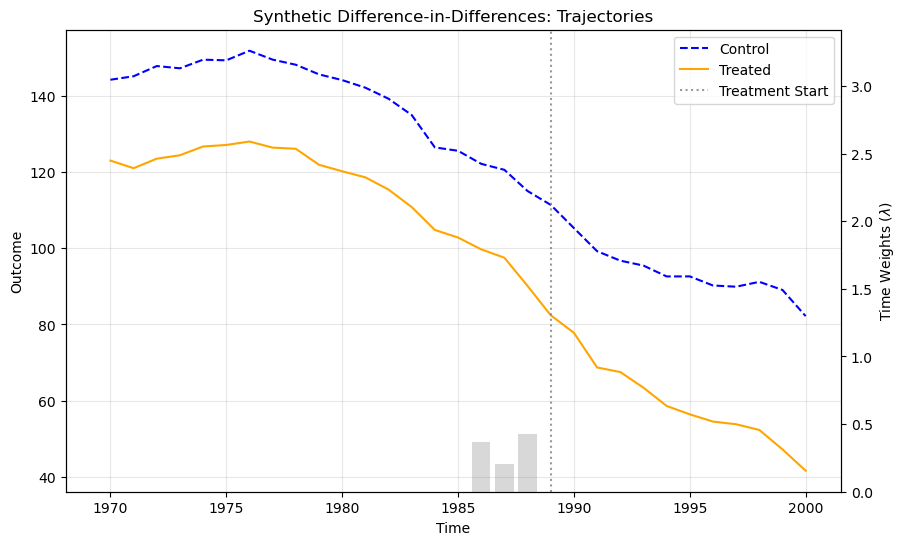

[-2.31857620e+01  0.00000000e+00  0.00000000e+00  9.58749027e-02
  2.65969279e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.54085729e-01  0.00000000e+00  0.00000000e+00  1.37700068e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  8.09856632e-02  9.25980461e-02
  2.27641105e-01  5.87257022e-02  0.00000000e+00  1.03495654e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00]


In [19]:
print(model4.ATT)
print(model4.ATT_diff)
model4.plot_trajectories()
print(model4.omega)